In [1]:
import tensorflow as tf
tf.random.set_seed(1)

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
import numpy as np
dataset=np.concatenate([x_train,x_test],axis=0)
##expand dimmensions and convert images from 28x28 to 28x28x1 as convolutional layers expect 3 channels
dataset=np.expand_dims(dataset,-1).astype('float32')/255

In [4]:
BATCH_SIZE=64
dataset=np.reshape(dataset,(-1,28,28,1))
dataset=tf.data.Dataset.from_tensor_slices(dataset)
dataset=dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
NOISE_DIM=150
generator=keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(NOISE_DIM,)),
    layers.Dense(7*7*256),
    layers.Reshape(target_shape=(7,7,256)),
    layers.Conv2DTranspose(256,3,activation='LeakyReLU',strides=2,padding='same'),
    layers.Conv2DTranspose(128,3,activation='LeakyReLU',strides=2,padding='same'),
    layers.Conv2DTranspose(1,3,activation='sigmoid',padding='same')
])
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 256)       590080    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         1153      
 Transpose)                                                      
                                                        

In [6]:
discriminator=keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(28,28,1)),
    layers.Conv2D(256,3,activation='relu',strides=2,padding='same'),
    layers.Conv2D(128,3,activation='relu',strides=2,padding='same'),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699137 (2.67 MB)
Trainable params: 69913

In [7]:
##we have to set different learning rate for generator as well as discriminator
##we have to maintain the game balance until we arrive at the equilibrium point
##if the discriminant gets strong or weak the GANs game fails, higher learning rate impact GANs as well
optimizerG=keras.optimizers.Adam(learning_rate=0.001,beta_1=0.5)
optimizerD=keras.optimizers.Adam(learning_rate=0.003,beta_1=0.5)
lossFn=keras.losses.BinaryCrossentropy(from_logits=True)  ##real or fake, hence binary loss used
gAccMetric=tf.keras.metrics.BinaryAccuracy()
dAccMetric=tf.keras.metrics.BinaryAccuracy()

In [8]:
@tf.function
def trainDStep(data):
  # the batch is (32,28,28,1), so extract 32 value
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))

  # concatenate the real and fake labels
  y_true = tf.concat(
    [
      # the original data is real, labeled with 1
      tf.ones(batchSize, 1),
      # the forged data is fake, labeled with 0
      tf.zeros(batchSize, 1)
    ],
    axis=0
  )
  with tf.GradientTape() as tape:
    fake = generator(noise)
    x = tf.concat([data, fake], axis=0)
    y_pred = discriminator(x)
    discriminatorLoss = lossFn(y_true, y_pred)
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))
  dAccMetric.update_state(y_true, y_pred)
  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetric.result()
  }

In [9]:
@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))
  y_true = tf.ones(batchSize, 1)
  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)
  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))
  gAccMetric.update_state(y_true, y_pred)
  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }

In [10]:
import matplotlib.pyplot as plt
def plotImages(model):
    images = model(np.random.normal(size=(81, NOISE_DIM)))
    plt.figure(figsize=(9, 9))
    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')
    plt.show();

E:0, Loss G:0.3147, Loss D:0.8124, Acc G:%97.12, Acc D:%50.42


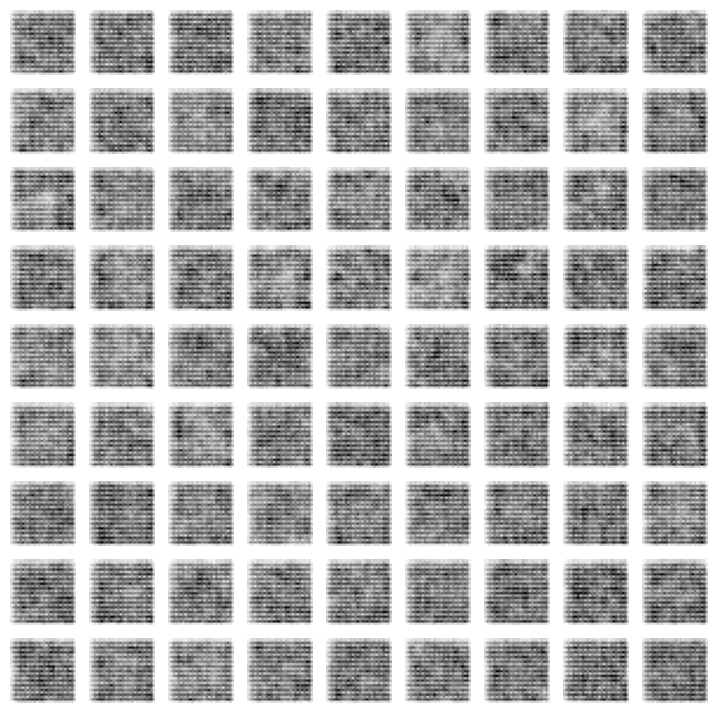

E:1, Loss G:0.3133, Loss D:0.8132, Acc G:%99.68, Acc D:%50.05
E:2, Loss G:0.3133, Loss D:0.8132, Acc G:%99.81, Acc D:%50.03


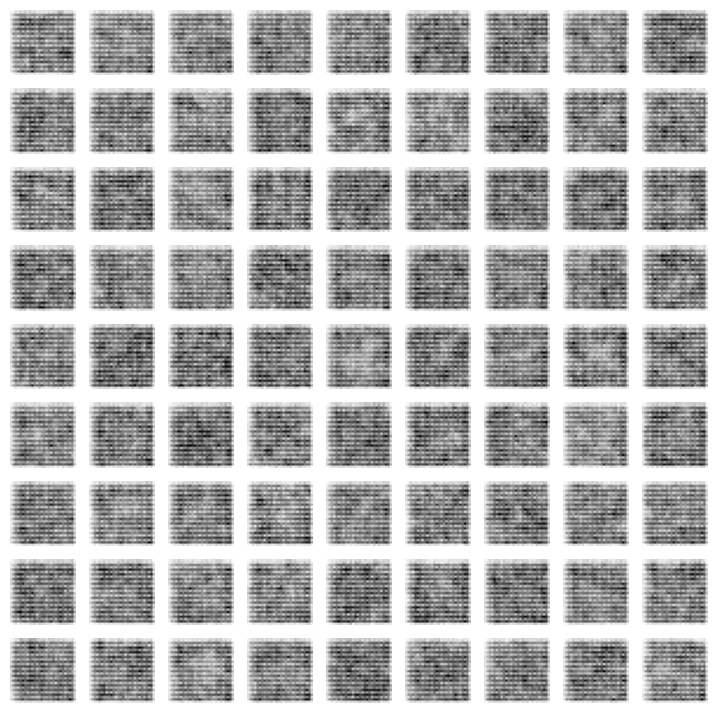

E:3, Loss G:0.3133, Loss D:0.8132, Acc G:%99.87, Acc D:%50.02
E:4, Loss G:0.3133, Loss D:0.8132, Acc G:%99.90, Acc D:%50.02


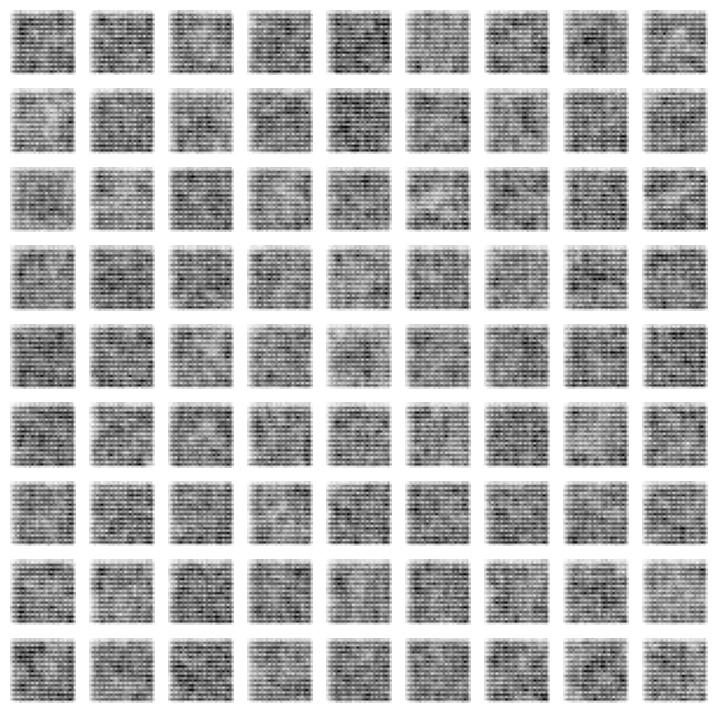

E:5, Loss G:0.3133, Loss D:0.8132, Acc G:%99.92, Acc D:%50.01
E:6, Loss G:0.3133, Loss D:0.8132, Acc G:%99.93, Acc D:%50.01


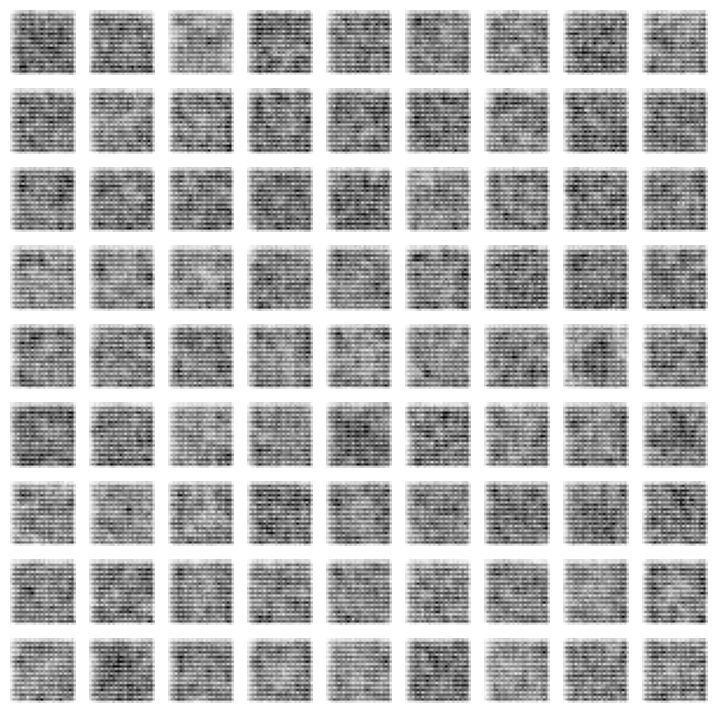

E:7, Loss G:0.3133, Loss D:0.8132, Acc G:%99.94, Acc D:%50.01
E:8, Loss G:0.3133, Loss D:0.8132, Acc G:%99.95, Acc D:%50.01


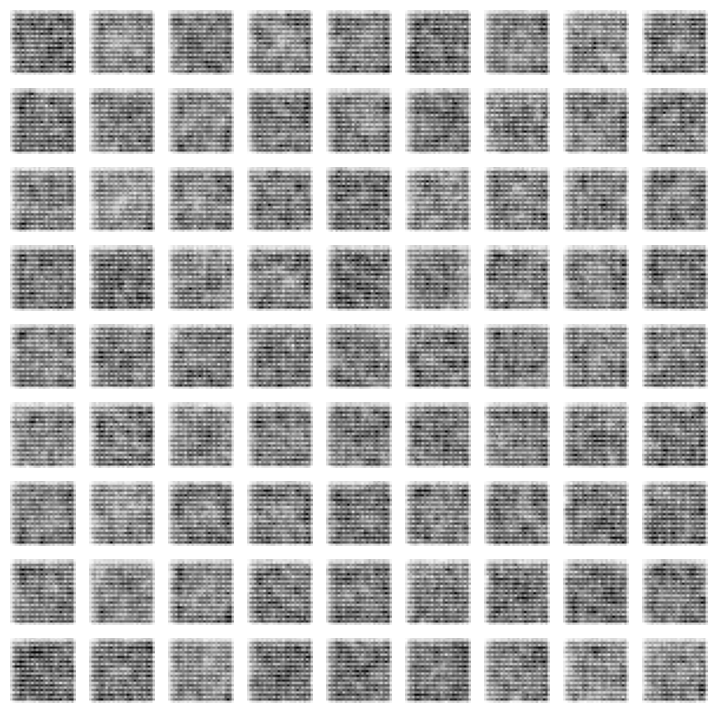

E:9, Loss G:0.3133, Loss D:0.8132, Acc G:%99.95, Acc D:%50.01
E:10, Loss G:0.3133, Loss D:0.8132, Acc G:%99.96, Acc D:%50.01


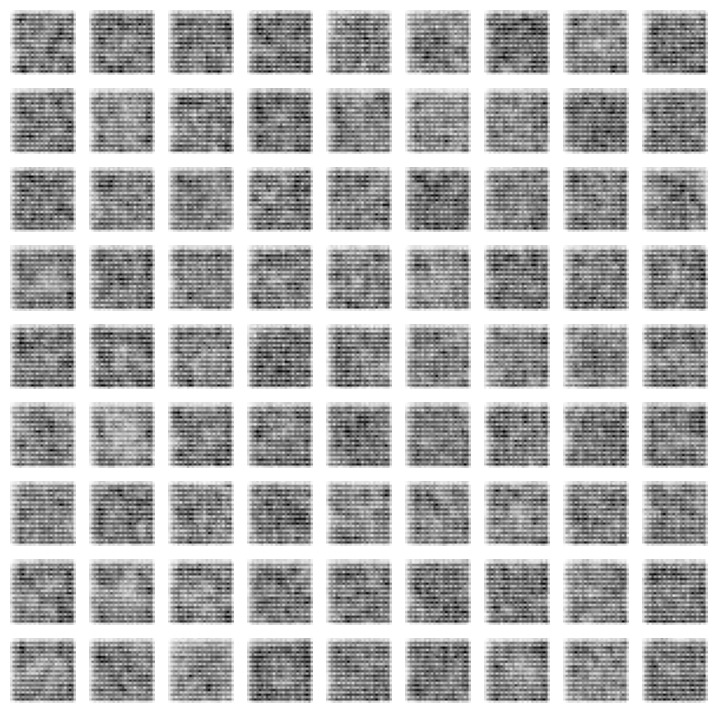

E:11, Loss G:0.3133, Loss D:0.8132, Acc G:%99.96, Acc D:%50.01
E:12, Loss G:0.3133, Loss D:0.8132, Acc G:%99.96, Acc D:%50.01


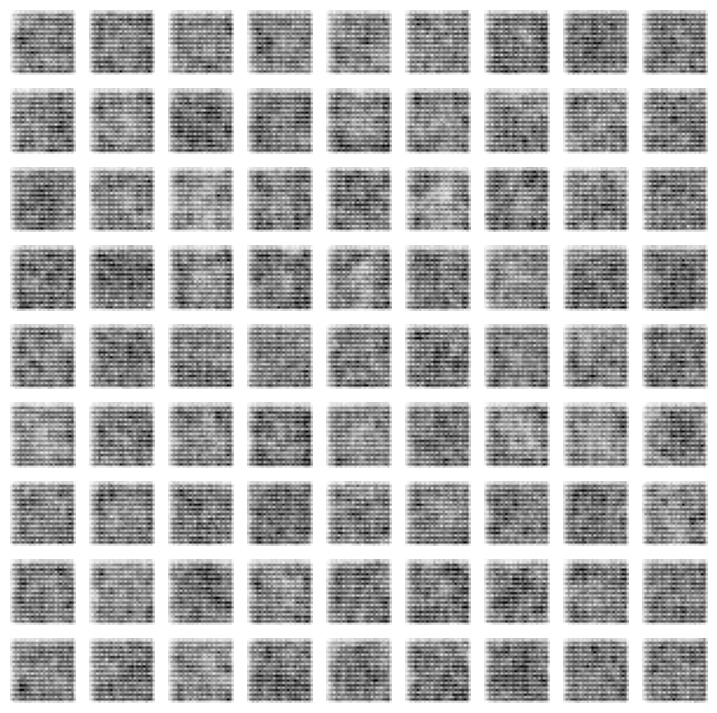

E:13, Loss G:0.3133, Loss D:0.8132, Acc G:%99.97, Acc D:%50.01
E:14, Loss G:0.3133, Loss D:0.8132, Acc G:%99.97, Acc D:%50.01


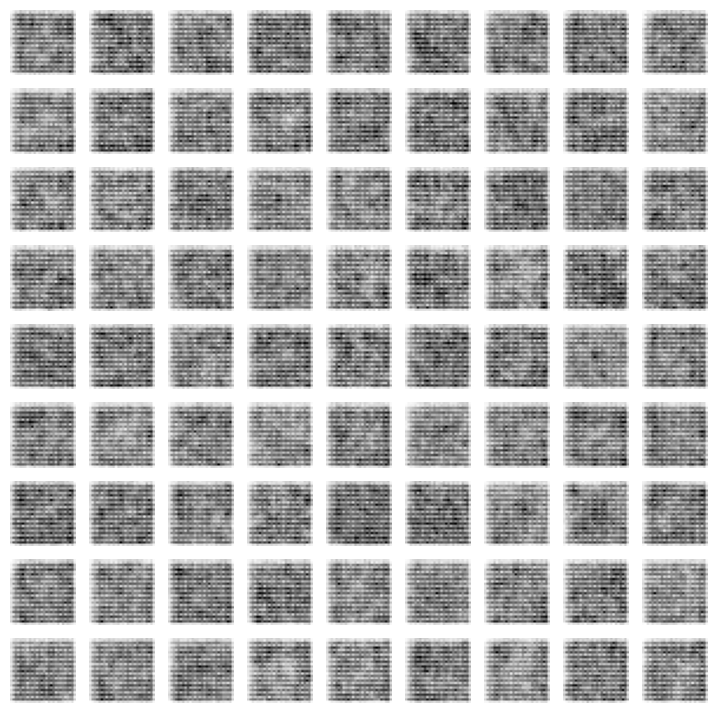

E:15, Loss G:0.3133, Loss D:0.8132, Acc G:%99.97, Acc D:%50.01
E:16, Loss G:0.3133, Loss D:0.8132, Acc G:%99.97, Acc D:%50.00


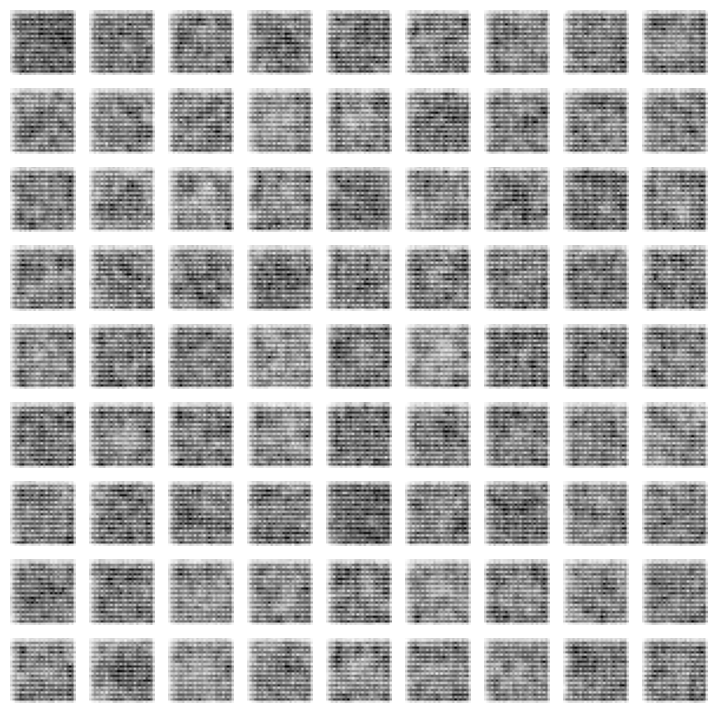

E:17, Loss G:0.3133, Loss D:0.8132, Acc G:%99.97, Acc D:%50.00
E:18, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00


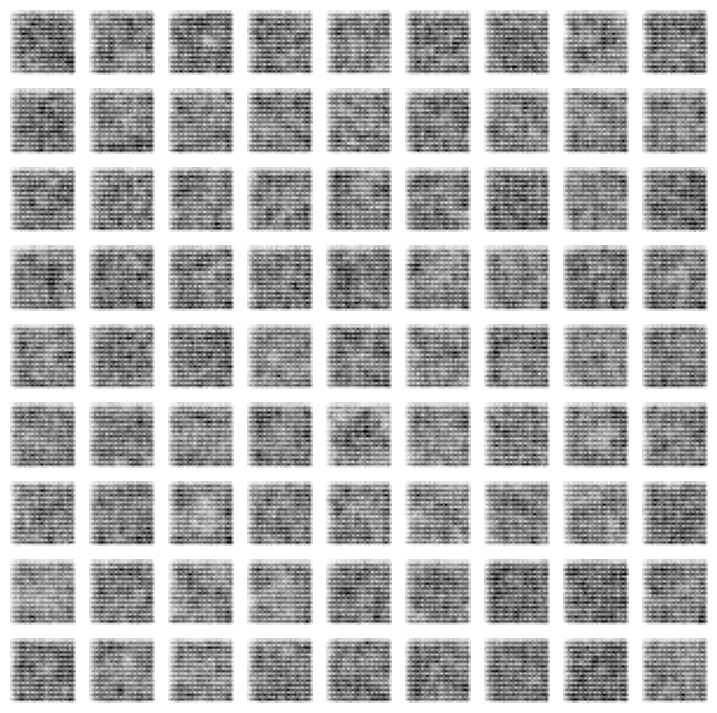

E:19, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00
E:20, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00


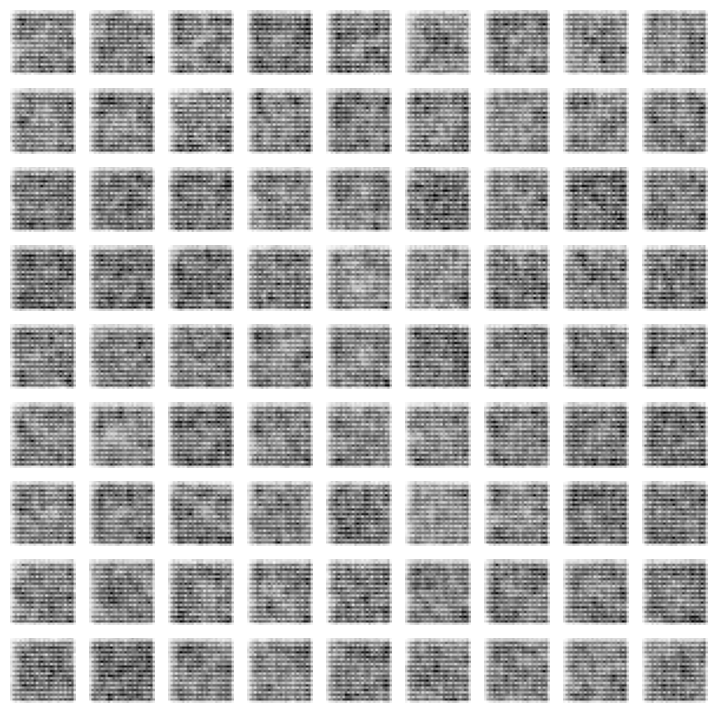

E:21, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00
E:22, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00


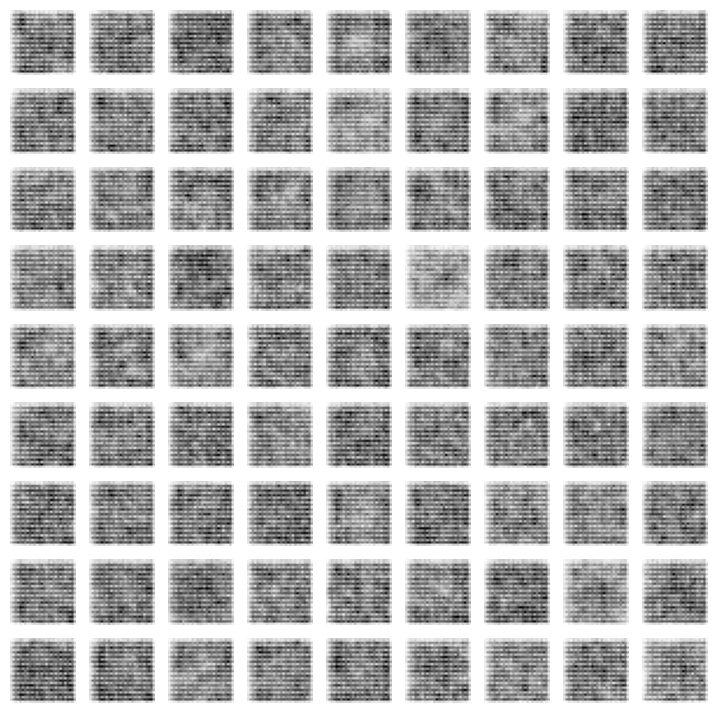

E:23, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00
E:24, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00


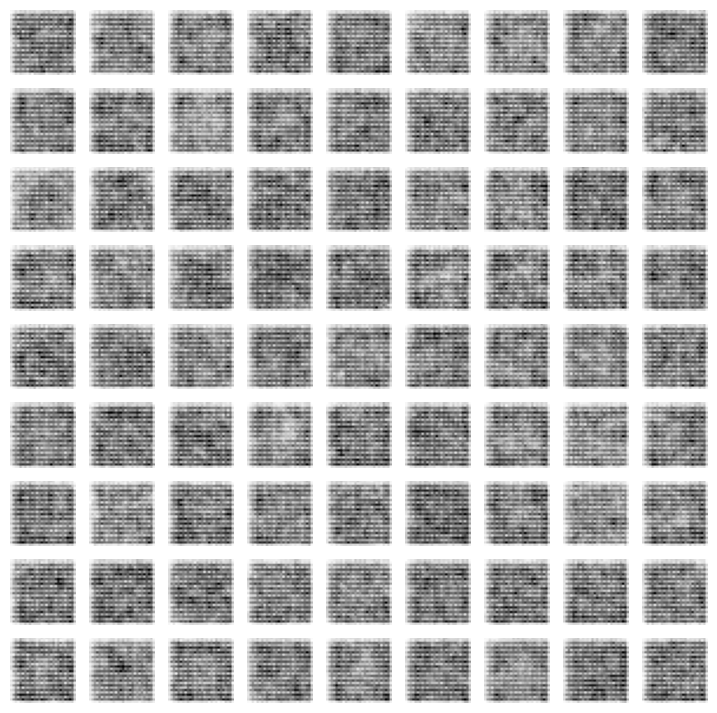

E:25, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00
E:26, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00


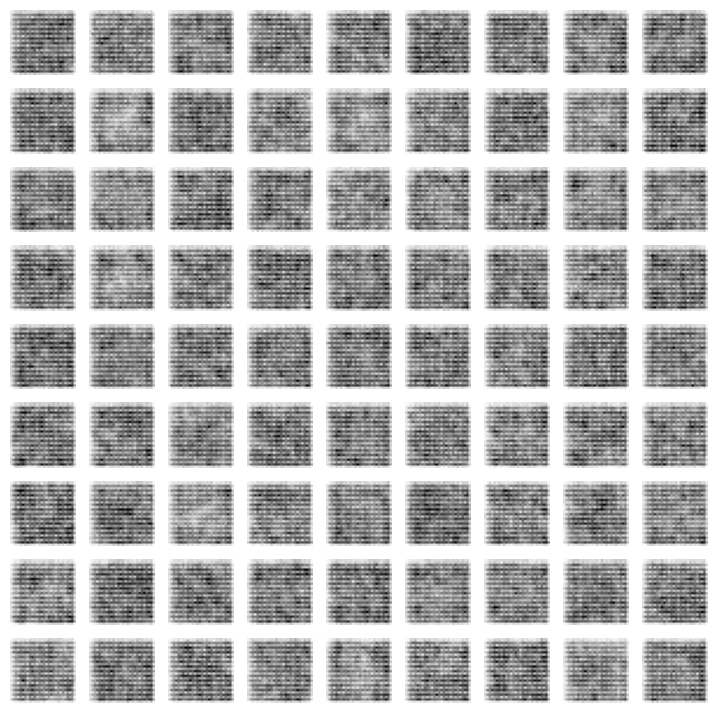

E:27, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00
E:28, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00


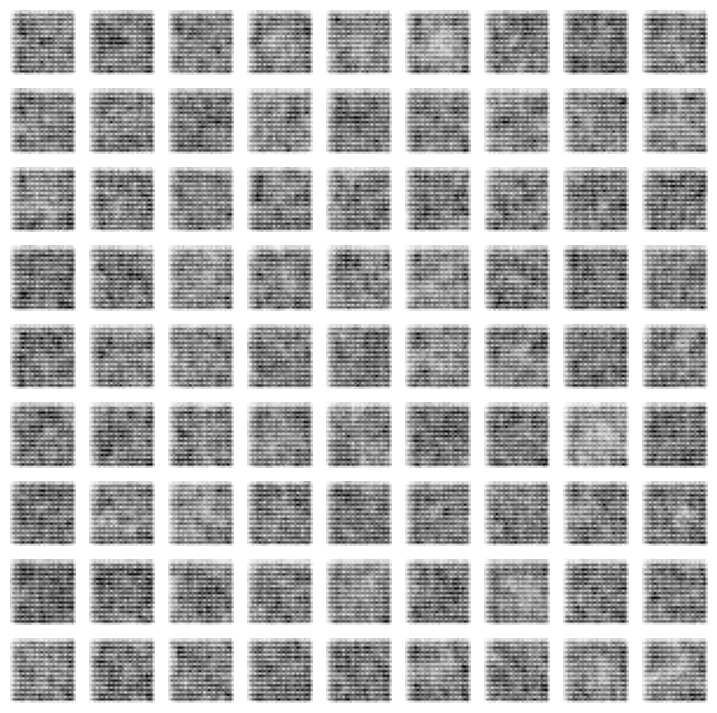

E:29, Loss G:0.3133, Loss D:0.8132, Acc G:%99.98, Acc D:%50.00


In [11]:
for epoch in range(30):
  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  cnt = 0
  for batch in dataset:
    dLoss = trainDStep(batch)
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']

    # train the generator
    gLoss = trainGStep(batch)
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    # increment the counter
    cnt += 1

  # log the performance
  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
  ))

  if epoch % 2 == 0:
    plotImages(generator)